# Import Datasets(dog & human)

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']) , 133)
    return dog_files , dog_targets

train_files , train_targets = load_dataset('dogImages/train')
valid_files , valid_targets = load_dataset('dogImages/valid')
test_files , test_targets = load_dataset('dogImages/test')

dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

print('there are %d total dog categories'% len(dog_names))
print('there are %s total dog images\n' %len(np.hstack([train_files , valid_files , test_files])))
print('there are %d training dog images' %len(train_files))
print('there are %d validation dog images' %len(valid_files))
print('there are %d testing dog images' %len(test_files))

Using TensorFlow backend.
c:\users\shaurya sinha\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\shaurya sinha\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\shaurya sinha\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

there are 133 total dog categories
there are 8351 total dog images

there are 6680 training dog images
there are 835 validation dog images
there are 836 testing dog images


In [2]:
import random
random.seed(8675309)

human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

print('there are %d total human images' %len(human_files))

there are 13233 total human images


# Detect humans

number of faces detected: 2


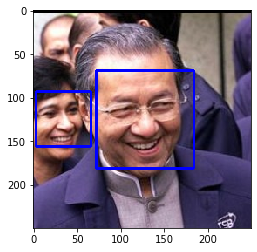

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

img = cv2.imread(human_files[14])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray)

print('number of faces detected:', len(faces))

for (x , y , w , h) in faces:
    cv2.rectangle(img , (x , y) , (x + w , y + h) , (255 , 0 , 0) , 2)
    
cv_rgb = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

plt.imshow(cv_rgb)
plt.show()

### Human Face Dectector :--

In [4]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
y = 0
z = 0

for i in range(len(human_files_short)):
    x = face_detector(human_files_short[i])
    if (x!=0):
        y = y+1

for i in range(len(dog_files_short)):
    x = face_detector(dog_files_short[i])
    if (x!=0):
        z = z+1
print('%d percentage of human images were with a detected human face' % (y))
print('%d percentage of dog images were with a detected human face' % (z))

99 percentage of human images were with a detected human face
12 percentage of dog images were with a detected human face


# Detect dogs

In [6]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights = 'imagenet')

W0825 12:07:22.501087  6320 deprecation_wrapper.py:119] From c:\users\shaurya sinha\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 12:07:22.519039  6320 deprecation_wrapper.py:119] From c:\users\shaurya sinha\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 12:07:22.524024  6320 deprecation_wrapper.py:119] From c:\users\shaurya sinha\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0825 12:07:22.550919  6320 deprecation_wrapper.py:119] From c:\users\shaurya sinha\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:190

### Preprocess the data :--

In [7]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path , target_size = (224 , 224))
    x = image.img_to_array(img)
    return np.expand_dims(x , axis = 0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making predictions :--

In [8]:
from keras.applications.resnet50 import preprocess_input , decode_predictions

def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Dog Detector

In [9]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return((prediction <= 268) & (prediction >= 151))

In [10]:
y = 0
z = 0

for i in range(len(human_files_short)):
    x = dog_detector(human_files_short[i])
    if (x == True):
        y = y+1

for i in range(len(dog_files_short)):
    x = dog_detector(dog_files_short[i])
    if (x == True):
        z = z+1
print('%d percentage of human images were with a detected human face' % (y))
print('%d percentage of dog images were with a detected human face' % (z))

1 percentage of human images were with a detected human face
100 percentage of dog images were with a detected human face


In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


 25%|███████████████████▌                                                         | 1695/6680 [00:08<00:25, 198.08it/s]


 51%|███████████████████████████████████████▌                                     | 3430/6680 [00:16<00:15, 213.46it/s]


 79%|████████████████████████████████████████████████████████████▉                | 5291/6680 [00:24<00:05, 233.77it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 6680/6680 [00:31<00:00, 214.70it/s]

 32%|█████████████████████████▏                                                     | 266/835 [00:01<00:03, 177.89it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 835/835 [00:04<00:00, 196.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:04<00:00, 208.76it/s]


# Model Architecture

In [15]:
from keras.layers import Conv2D , MaxPooling2D , GlobalAveragePooling2D
from keras.layers import Dropout , Flatten , Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters = 16 , kernel_size = 2 , padding = 'same' , activation = 'relu' , input_shape = (224 , 224 , 3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32 , kernel_size = 2 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64 , kernel_size = 2 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512 , activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(133 , activation = 'softmax'))
model.summary()

W0825 12:13:06.477095  6320 deprecation.py:506] From c:\users\shaurya sinha\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)       

# Compile the model

In [16]:
model.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])


W0825 12:13:10.443523  6320 deprecation_wrapper.py:119] From c:\users\shaurya sinha\appdata\local\programs\python\python36\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



# Train the model

In [17]:
from keras.callbacks import ModelCheckpoint  

epochs = 25

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5' , verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets , validation_data=(valid_tensors, valid_targets) , epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

W0825 12:13:13.323698  6320 deprecation.py:323] From c:\users\shaurya sinha\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6680 samples, validate on 835 samples
Epoch 1/25


4160/6680 [=================>............] - ETA: 13:49 - loss: 4.8892 - acc: 0.0000e+ - ETA: 7:32 - loss: 9.6660 - acc: 0.0000e+00 - ETA: 5:25 - loss: 9.8133 - acc: 0.0000e+0 - ETA: 4:22 - loss: 8.7495 - acc: 0.0000e+0 - ETA: 3:43 - loss: 8.1379 - acc: 0.0000e+0 - ETA: 3:18 - loss: 7.5994 - acc: 0.0000e+0 - ETA: 3:00 - loss: 7.2100 - acc: 0.0071    - ETA: 2:46 - loss: 6.9406 - acc: 0.006 - ETA: 2:35 - loss: 6.7256 - acc: 0.005 - ETA: 2:27 - loss: 6.5449 - acc: 0.005 - ETA: 2:19 - loss: 6.4015 - acc: 0.004 - ETA: 2:13 - loss: 6.2818 - acc: 0.004 - ETA: 2:08 - loss: 6.1761 - acc: 0.007 - ETA: 2:04 - loss: 6.0876 - acc: 0.007 - ETA: 2:00 - loss: 6.0085 - acc: 0.006 - ETA: 1:57 - loss: 5.9395 - acc: 0.006 - ETA: 1:53 - loss: 5.8770 - acc: 0.005 - ETA: 1:51 - loss: 5.8238 - acc: 0.005 - ETA: 1:48 - loss: 5.7747 - acc: 0.005 - ETA: 1:46 - loss: 5.7300 - acc: 0.005 - ETA: 1:44 - loss: 5.6894 - acc: 0.007 - ETA: 1:42 - loss: 5.6527 - acc: 0.006 - ETA: 1:40 - loss: 5.6198 - acc: 0.006 - ETA: 1

6680/6680 [==============================] - ETA: 29s - loss: 4.9303 - acc: 0.01 - ETA: 29s - loss: 4.9289 - acc: 0.01 - ETA: 29s - loss: 4.9291 - acc: 0.01 - ETA: 28s - loss: 4.9293 - acc: 0.01 - ETA: 28s - loss: 4.9285 - acc: 0.01 - ETA: 28s - loss: 4.9270 - acc: 0.01 - ETA: 28s - loss: 4.9262 - acc: 0.01 - ETA: 27s - loss: 4.9257 - acc: 0.01 - ETA: 27s - loss: 4.9244 - acc: 0.01 - ETA: 27s - loss: 4.9236 - acc: 0.01 - ETA: 27s - loss: 4.9228 - acc: 0.01 - ETA: 26s - loss: 4.9220 - acc: 0.01 - ETA: 26s - loss: 4.9209 - acc: 0.01 - ETA: 26s - loss: 4.9198 - acc: 0.01 - ETA: 26s - loss: 4.9196 - acc: 0.01 - ETA: 25s - loss: 4.9184 - acc: 0.01 - ETA: 25s - loss: 4.9172 - acc: 0.01 - ETA: 25s - loss: 4.9166 - acc: 0.01 - ETA: 25s - loss: 4.9157 - acc: 0.01 - ETA: 24s - loss: 4.9155 - acc: 0.01 - ETA: 24s - loss: 4.9144 - acc: 0.01 - ETA: 24s - loss: 4.9137 - acc: 0.01 - ETA: 24s - loss: 4.9134 - acc: 0.01 - ETA: 23s - loss: 4.9128 - acc: 0.01 - ETA: 23s - loss: 4.9119 - acc: 0.01 - ETA: 

4220/6680 [=================>............] - ETA: 1:13 - loss: 4.5038 - acc: 0.100 - ETA: 1:13 - loss: 4.3987 - acc: 0.075 - ETA: 1:13 - loss: 4.4371 - acc: 0.100 - ETA: 1:13 - loss: 4.4211 - acc: 0.100 - ETA: 1:13 - loss: 4.3907 - acc: 0.090 - ETA: 1:12 - loss: 4.4256 - acc: 0.075 - ETA: 1:12 - loss: 4.4084 - acc: 0.085 - ETA: 1:12 - loss: 4.4073 - acc: 0.075 - ETA: 1:12 - loss: 4.4124 - acc: 0.083 - ETA: 1:12 - loss: 4.4159 - acc: 0.080 - ETA: 1:12 - loss: 4.4336 - acc: 0.072 - ETA: 1:12 - loss: 4.4094 - acc: 0.070 - ETA: 1:11 - loss: 4.4188 - acc: 0.069 - ETA: 1:11 - loss: 4.4274 - acc: 0.064 - ETA: 1:11 - loss: 4.4263 - acc: 0.066 - ETA: 1:11 - loss: 4.4432 - acc: 0.062 - ETA: 1:10 - loss: 4.4498 - acc: 0.064 - ETA: 1:10 - loss: 4.4661 - acc: 0.061 - ETA: 1:10 - loss: 4.4641 - acc: 0.057 - ETA: 1:10 - loss: 4.4710 - acc: 0.055 - ETA: 1:10 - loss: 4.4776 - acc: 0.052 - ETA: 1:09 - loss: 4.4872 - acc: 0.050 - ETA: 1:09 - loss: 4.4811 - acc: 0.052 - ETA: 1:09 - loss: 4.4791 - acc: 0.0

6680/6680 [==============================] - ETA: 27s - loss: 4.3886 - acc: 0.05 - ETA: 27s - loss: 4.3890 - acc: 0.05 - ETA: 27s - loss: 4.3893 - acc: 0.05 - ETA: 27s - loss: 4.3899 - acc: 0.05 - ETA: 26s - loss: 4.3898 - acc: 0.05 - ETA: 26s - loss: 4.3892 - acc: 0.05 - ETA: 26s - loss: 4.3896 - acc: 0.05 - ETA: 26s - loss: 4.3898 - acc: 0.05 - ETA: 26s - loss: 4.3906 - acc: 0.05 - ETA: 25s - loss: 4.3896 - acc: 0.05 - ETA: 25s - loss: 4.3884 - acc: 0.05 - ETA: 25s - loss: 4.3886 - acc: 0.05 - ETA: 25s - loss: 4.3888 - acc: 0.05 - ETA: 24s - loss: 4.3884 - acc: 0.05 - ETA: 24s - loss: 4.3872 - acc: 0.05 - ETA: 24s - loss: 4.3867 - acc: 0.05 - ETA: 24s - loss: 4.3854 - acc: 0.05 - ETA: 24s - loss: 4.3848 - acc: 0.05 - ETA: 23s - loss: 4.3849 - acc: 0.05 - ETA: 23s - loss: 4.3849 - acc: 0.05 - ETA: 23s - loss: 4.3854 - acc: 0.05 - ETA: 23s - loss: 4.3849 - acc: 0.05 - ETA: 22s - loss: 4.3845 - acc: 0.05 - ETA: 22s - loss: 4.3842 - acc: 0.05 - ETA: 22s - loss: 4.3847 - acc: 0.05 - ETA: 

4120/6680 [=================>............] - ETA: 1:17 - loss: 4.1776 - acc: 0.050 - ETA: 1:17 - loss: 4.0593 - acc: 0.075 - ETA: 1:17 - loss: 3.9573 - acc: 0.066 - ETA: 1:17 - loss: 3.9309 - acc: 0.100 - ETA: 1:17 - loss: 3.9783 - acc: 0.100 - ETA: 1:17 - loss: 3.9160 - acc: 0.125 - ETA: 1:16 - loss: 3.8641 - acc: 0.150 - ETA: 1:16 - loss: 3.9032 - acc: 0.137 - ETA: 1:16 - loss: 3.8801 - acc: 0.138 - ETA: 1:16 - loss: 3.9108 - acc: 0.130 - ETA: 1:16 - loss: 3.9064 - acc: 0.127 - ETA: 1:15 - loss: 3.9308 - acc: 0.141 - ETA: 1:15 - loss: 3.9392 - acc: 0.142 - ETA: 1:15 - loss: 3.9542 - acc: 0.135 - ETA: 1:15 - loss: 3.9582 - acc: 0.130 - ETA: 1:15 - loss: 3.9541 - acc: 0.128 - ETA: 1:15 - loss: 3.9291 - acc: 0.129 - ETA: 1:15 - loss: 3.9210 - acc: 0.133 - ETA: 1:14 - loss: 3.9207 - acc: 0.134 - ETA: 1:14 - loss: 3.9329 - acc: 0.130 - ETA: 1:14 - loss: 3.9302 - acc: 0.131 - ETA: 1:14 - loss: 3.8985 - acc: 0.136 - ETA: 1:14 - loss: 3.9006 - acc: 0.139 - ETA: 1:14 - loss: 3.8811 - acc: 0.1

6680/6680 [==============================] - ETA: 44s - loss: 3.8026 - acc: 0.14 - ETA: 44s - loss: 3.8042 - acc: 0.14 - ETA: 44s - loss: 3.8025 - acc: 0.14 - ETA: 43s - loss: 3.8040 - acc: 0.14 - ETA: 43s - loss: 3.8036 - acc: 0.14 - ETA: 43s - loss: 3.8030 - acc: 0.14 - ETA: 43s - loss: 3.8027 - acc: 0.14 - ETA: 42s - loss: 3.7994 - acc: 0.14 - ETA: 42s - loss: 3.8019 - acc: 0.14 - ETA: 42s - loss: 3.8032 - acc: 0.14 - ETA: 42s - loss: 3.8055 - acc: 0.14 - ETA: 41s - loss: 3.8074 - acc: 0.14 - ETA: 41s - loss: 3.8078 - acc: 0.14 - ETA: 41s - loss: 3.8080 - acc: 0.14 - ETA: 41s - loss: 3.8076 - acc: 0.14 - ETA: 40s - loss: 3.8078 - acc: 0.14 - ETA: 40s - loss: 3.8093 - acc: 0.14 - ETA: 40s - loss: 3.8071 - acc: 0.14 - ETA: 40s - loss: 3.8073 - acc: 0.14 - ETA: 39s - loss: 3.8085 - acc: 0.14 - ETA: 39s - loss: 3.8077 - acc: 0.14 - ETA: 39s - loss: 3.8064 - acc: 0.14 - ETA: 38s - loss: 3.8046 - acc: 0.14 - ETA: 38s - loss: 3.8053 - acc: 0.14 - ETA: 38s - loss: 3.8046 - acc: 0.14 - ETA: 

4140/6680 [=================>............] - ETA: 1:18 - loss: 3.2354 - acc: 0.300 - ETA: 1:18 - loss: 3.2146 - acc: 0.300 - ETA: 1:18 - loss: 3.1256 - acc: 0.283 - ETA: 1:18 - loss: 3.1839 - acc: 0.300 - ETA: 1:17 - loss: 3.2282 - acc: 0.280 - ETA: 1:17 - loss: 3.2363 - acc: 0.250 - ETA: 1:17 - loss: 3.2130 - acc: 0.235 - ETA: 1:17 - loss: 3.2165 - acc: 0.225 - ETA: 1:16 - loss: 3.2233 - acc: 0.233 - ETA: 1:16 - loss: 3.1736 - acc: 0.245 - ETA: 1:16 - loss: 3.0925 - acc: 0.277 - ETA: 1:16 - loss: 3.1349 - acc: 0.262 - ETA: 1:16 - loss: 3.0955 - acc: 0.265 - ETA: 1:15 - loss: 3.1038 - acc: 0.264 - ETA: 1:15 - loss: 3.1148 - acc: 0.270 - ETA: 1:15 - loss: 3.0954 - acc: 0.271 - ETA: 1:15 - loss: 3.0815 - acc: 0.285 - ETA: 1:14 - loss: 3.0685 - acc: 0.294 - ETA: 1:14 - loss: 3.0635 - acc: 0.297 - ETA: 1:14 - loss: 3.0663 - acc: 0.297 - ETA: 1:14 - loss: 3.0651 - acc: 0.295 - ETA: 1:14 - loss: 3.0590 - acc: 0.288 - ETA: 1:13 - loss: 3.0445 - acc: 0.291 - ETA: 1:13 - loss: 3.0481 - acc: 0.2

6680/6680 [==============================] - ETA: 45s - loss: 2.8513 - acc: 0.32 - ETA: 45s - loss: 2.8517 - acc: 0.32 - ETA: 44s - loss: 2.8508 - acc: 0.32 - ETA: 44s - loss: 2.8514 - acc: 0.32 - ETA: 43s - loss: 2.8529 - acc: 0.32 - ETA: 43s - loss: 2.8547 - acc: 0.32 - ETA: 42s - loss: 2.8528 - acc: 0.32 - ETA: 42s - loss: 2.8533 - acc: 0.32 - ETA: 42s - loss: 2.8506 - acc: 0.32 - ETA: 41s - loss: 2.8485 - acc: 0.32 - ETA: 41s - loss: 2.8487 - acc: 0.32 - ETA: 40s - loss: 2.8489 - acc: 0.32 - ETA: 40s - loss: 2.8488 - acc: 0.32 - ETA: 39s - loss: 2.8508 - acc: 0.32 - ETA: 39s - loss: 2.8497 - acc: 0.32 - ETA: 39s - loss: 2.8506 - acc: 0.32 - ETA: 38s - loss: 2.8518 - acc: 0.31 - ETA: 38s - loss: 2.8525 - acc: 0.31 - ETA: 37s - loss: 2.8553 - acc: 0.31 - ETA: 37s - loss: 2.8542 - acc: 0.31 - ETA: 37s - loss: 2.8543 - acc: 0.31 - ETA: 36s - loss: 2.8523 - acc: 0.32 - ETA: 36s - loss: 2.8509 - acc: 0.32 - ETA: 35s - loss: 2.8500 - acc: 0.32 - ETA: 35s - loss: 2.8469 - acc: 0.32 - ETA: 

4120/6680 [=================>............] - ETA: 1:18 - loss: 1.5867 - acc: 0.800 - ETA: 1:19 - loss: 1.6269 - acc: 0.725 - ETA: 1:19 - loss: 1.5455 - acc: 0.750 - ETA: 1:18 - loss: 1.4641 - acc: 0.737 - ETA: 1:18 - loss: 1.6102 - acc: 0.670 - ETA: 1:18 - loss: 1.6536 - acc: 0.650 - ETA: 1:18 - loss: 1.7904 - acc: 0.621 - ETA: 1:17 - loss: 1.7630 - acc: 0.618 - ETA: 1:17 - loss: 1.7808 - acc: 0.616 - ETA: 1:17 - loss: 1.7454 - acc: 0.625 - ETA: 1:17 - loss: 1.6852 - acc: 0.640 - ETA: 1:17 - loss: 1.7021 - acc: 0.633 - ETA: 1:17 - loss: 1.7408 - acc: 0.623 - ETA: 1:16 - loss: 1.7221 - acc: 0.621 - ETA: 1:16 - loss: 1.6711 - acc: 0.630 - ETA: 1:16 - loss: 1.6906 - acc: 0.615 - ETA: 1:16 - loss: 1.6873 - acc: 0.608 - ETA: 1:15 - loss: 1.6986 - acc: 0.602 - ETA: 1:15 - loss: 1.7328 - acc: 0.594 - ETA: 1:15 - loss: 1.7233 - acc: 0.600 - ETA: 1:15 - loss: 1.7311 - acc: 0.597 - ETA: 1:15 - loss: 1.7102 - acc: 0.600 - ETA: 1:15 - loss: 1.7187 - acc: 0.600 - ETA: 1:14 - loss: 1.7277 - acc: 0.5

6680/6680 [==============================] - ETA: 43s - loss: 1.7552 - acc: 0.57 - ETA: 42s - loss: 1.7523 - acc: 0.57 - ETA: 42s - loss: 1.7541 - acc: 0.57 - ETA: 41s - loss: 1.7544 - acc: 0.57 - ETA: 41s - loss: 1.7547 - acc: 0.57 - ETA: 41s - loss: 1.7554 - acc: 0.57 - ETA: 40s - loss: 1.7579 - acc: 0.57 - ETA: 40s - loss: 1.7602 - acc: 0.56 - ETA: 40s - loss: 1.7641 - acc: 0.56 - ETA: 39s - loss: 1.7666 - acc: 0.56 - ETA: 39s - loss: 1.7702 - acc: 0.56 - ETA: 38s - loss: 1.7709 - acc: 0.56 - ETA: 38s - loss: 1.7714 - acc: 0.56 - ETA: 38s - loss: 1.7720 - acc: 0.56 - ETA: 37s - loss: 1.7723 - acc: 0.56 - ETA: 37s - loss: 1.7741 - acc: 0.56 - ETA: 36s - loss: 1.7725 - acc: 0.56 - ETA: 36s - loss: 1.7748 - acc: 0.56 - ETA: 36s - loss: 1.7747 - acc: 0.56 - ETA: 35s - loss: 1.7727 - acc: 0.56 - ETA: 35s - loss: 1.7727 - acc: 0.56 - ETA: 35s - loss: 1.7726 - acc: 0.56 - ETA: 35s - loss: 1.7737 - acc: 0.56 - ETA: 34s - loss: 1.7790 - acc: 0.56 - ETA: 34s - loss: 1.7799 - acc: 0.56 - ETA: 

4100/6680 [=================>............] - ETA: 3:02 - loss: 1.0674 - acc: 0.650 - ETA: 3:02 - loss: 0.9516 - acc: 0.750 - ETA: 3:02 - loss: 0.9087 - acc: 0.733 - ETA: 3:02 - loss: 1.0017 - acc: 0.712 - ETA: 3:02 - loss: 0.9119 - acc: 0.760 - ETA: 3:01 - loss: 0.9668 - acc: 0.750 - ETA: 3:01 - loss: 0.9846 - acc: 0.742 - ETA: 3:00 - loss: 1.0176 - acc: 0.725 - ETA: 3:00 - loss: 1.0142 - acc: 0.733 - ETA: 3:00 - loss: 0.9979 - acc: 0.740 - ETA: 2:59 - loss: 1.0081 - acc: 0.736 - ETA: 2:59 - loss: 0.9997 - acc: 0.737 - ETA: 2:58 - loss: 0.9863 - acc: 0.738 - ETA: 2:58 - loss: 0.9691 - acc: 0.742 - ETA: 2:57 - loss: 0.9558 - acc: 0.746 - ETA: 2:56 - loss: 0.9241 - acc: 0.759 - ETA: 2:56 - loss: 0.9164 - acc: 0.764 - ETA: 2:55 - loss: 0.9225 - acc: 0.763 - ETA: 2:55 - loss: 0.9630 - acc: 0.763 - ETA: 2:54 - loss: 0.9577 - acc: 0.762 - ETA: 2:53 - loss: 0.9858 - acc: 0.759 - ETA: 2:53 - loss: 0.9840 - acc: 0.759 - ETA: 2:53 - loss: 0.9810 - acc: 0.756 - ETA: 2:52 - loss: 0.9770 - acc: 0.7

6680/6680 [==============================] - ETA: 50s - loss: 0.9663 - acc: 0.75 - ETA: 49s - loss: 0.9665 - acc: 0.75 - ETA: 49s - loss: 0.9672 - acc: 0.75 - ETA: 49s - loss: 0.9671 - acc: 0.75 - ETA: 48s - loss: 0.9676 - acc: 0.75 - ETA: 48s - loss: 0.9674 - acc: 0.75 - ETA: 48s - loss: 0.9673 - acc: 0.75 - ETA: 47s - loss: 0.9698 - acc: 0.75 - ETA: 47s - loss: 0.9709 - acc: 0.75 - ETA: 47s - loss: 0.9730 - acc: 0.75 - ETA: 47s - loss: 0.9715 - acc: 0.75 - ETA: 46s - loss: 0.9710 - acc: 0.75 - ETA: 46s - loss: 0.9708 - acc: 0.75 - ETA: 46s - loss: 0.9692 - acc: 0.75 - ETA: 45s - loss: 0.9672 - acc: 0.75 - ETA: 45s - loss: 0.9658 - acc: 0.75 - ETA: 45s - loss: 0.9666 - acc: 0.75 - ETA: 44s - loss: 0.9675 - acc: 0.75 - ETA: 44s - loss: 0.9675 - acc: 0.75 - ETA: 44s - loss: 0.9651 - acc: 0.75 - ETA: 43s - loss: 0.9663 - acc: 0.75 - ETA: 43s - loss: 0.9669 - acc: 0.75 - ETA: 43s - loss: 0.9676 - acc: 0.75 - ETA: 42s - loss: 0.9700 - acc: 0.75 - ETA: 42s - loss: 0.9711 - acc: 0.75 - ETA: 

4120/6680 [=================>............] - ETA: 3:04 - loss: 0.1055 - acc: 1.000 - ETA: 3:03 - loss: 0.1252 - acc: 0.975 - ETA: 3:03 - loss: 0.2112 - acc: 0.983 - ETA: 3:03 - loss: 0.3002 - acc: 0.950 - ETA: 3:02 - loss: 0.3984 - acc: 0.920 - ETA: 3:01 - loss: 0.4211 - acc: 0.908 - ETA: 3:01 - loss: 0.4595 - acc: 0.900 - ETA: 3:01 - loss: 0.4925 - acc: 0.900 - ETA: 3:00 - loss: 0.4786 - acc: 0.900 - ETA: 2:59 - loss: 0.4735 - acc: 0.895 - ETA: 2:59 - loss: 0.4412 - acc: 0.904 - ETA: 2:58 - loss: 0.4276 - acc: 0.904 - ETA: 2:58 - loss: 0.4308 - acc: 0.903 - ETA: 2:57 - loss: 0.4564 - acc: 0.896 - ETA: 2:56 - loss: 0.4890 - acc: 0.890 - ETA: 2:56 - loss: 0.4841 - acc: 0.884 - ETA: 2:55 - loss: 0.4848 - acc: 0.885 - ETA: 2:55 - loss: 0.4748 - acc: 0.888 - ETA: 2:54 - loss: 0.4722 - acc: 0.889 - ETA: 2:54 - loss: 0.4754 - acc: 0.887 - ETA: 2:53 - loss: 0.4848 - acc: 0.885 - ETA: 2:53 - loss: 0.4835 - acc: 0.886 - ETA: 2:48 - loss: 0.4980 - acc: 0.882 - ETA: 2:43 - loss: 0.4896 - acc: 0.8

6680/6680 [==============================] - ETA: 47s - loss: 0.5416 - acc: 0.85 - ETA: 47s - loss: 0.5435 - acc: 0.85 - ETA: 47s - loss: 0.5446 - acc: 0.85 - ETA: 46s - loss: 0.5450 - acc: 0.85 - ETA: 46s - loss: 0.5454 - acc: 0.85 - ETA: 46s - loss: 0.5449 - acc: 0.85 - ETA: 46s - loss: 0.5443 - acc: 0.85 - ETA: 45s - loss: 0.5452 - acc: 0.85 - ETA: 45s - loss: 0.5462 - acc: 0.85 - ETA: 45s - loss: 0.5461 - acc: 0.85 - ETA: 44s - loss: 0.5467 - acc: 0.85 - ETA: 44s - loss: 0.5471 - acc: 0.85 - ETA: 44s - loss: 0.5475 - acc: 0.85 - ETA: 44s - loss: 0.5476 - acc: 0.85 - ETA: 43s - loss: 0.5470 - acc: 0.85 - ETA: 43s - loss: 0.5469 - acc: 0.85 - ETA: 43s - loss: 0.5471 - acc: 0.85 - ETA: 42s - loss: 0.5499 - acc: 0.85 - ETA: 42s - loss: 0.5499 - acc: 0.85 - ETA: 42s - loss: 0.5502 - acc: 0.85 - ETA: 41s - loss: 0.5498 - acc: 0.85 - ETA: 41s - loss: 0.5507 - acc: 0.85 - ETA: 41s - loss: 0.5505 - acc: 0.85 - ETA: 40s - loss: 0.5507 - acc: 0.85 - ETA: 40s - loss: 0.5501 - acc: 0.85 - ETA: 

4120/6680 [=================>............] - ETA: 1:17 - loss: 0.2340 - acc: 0.900 - ETA: 1:17 - loss: 0.2544 - acc: 0.925 - ETA: 1:17 - loss: 0.2441 - acc: 0.950 - ETA: 1:17 - loss: 0.2825 - acc: 0.950 - ETA: 1:17 - loss: 0.2409 - acc: 0.960 - ETA: 1:17 - loss: 0.2203 - acc: 0.966 - ETA: 1:17 - loss: 0.2396 - acc: 0.950 - ETA: 1:17 - loss: 0.3271 - acc: 0.925 - ETA: 1:16 - loss: 0.4292 - acc: 0.900 - ETA: 1:16 - loss: 0.4106 - acc: 0.905 - ETA: 1:16 - loss: 0.3990 - acc: 0.904 - ETA: 1:16 - loss: 0.3726 - acc: 0.912 - ETA: 1:16 - loss: 0.3820 - acc: 0.907 - ETA: 1:16 - loss: 0.3689 - acc: 0.907 - ETA: 1:15 - loss: 0.3927 - acc: 0.906 - ETA: 1:15 - loss: 0.4013 - acc: 0.900 - ETA: 1:15 - loss: 0.3903 - acc: 0.902 - ETA: 1:15 - loss: 0.3768 - acc: 0.905 - ETA: 1:14 - loss: 0.3740 - acc: 0.905 - ETA: 1:14 - loss: 0.3585 - acc: 0.910 - ETA: 1:14 - loss: 0.3505 - acc: 0.909 - ETA: 1:14 - loss: 0.3375 - acc: 0.913 - ETA: 1:13 - loss: 0.3380 - acc: 0.913 - ETA: 1:13 - loss: 0.3268 - acc: 0.9

6680/6680 [==============================] - ETA: 49s - loss: 0.3449 - acc: 0.90 - ETA: 48s - loss: 0.3443 - acc: 0.90 - ETA: 48s - loss: 0.3448 - acc: 0.90 - ETA: 47s - loss: 0.3452 - acc: 0.90 - ETA: 47s - loss: 0.3448 - acc: 0.90 - ETA: 46s - loss: 0.3457 - acc: 0.90 - ETA: 46s - loss: 0.3473 - acc: 0.90 - ETA: 45s - loss: 0.3479 - acc: 0.90 - ETA: 45s - loss: 0.3493 - acc: 0.90 - ETA: 44s - loss: 0.3489 - acc: 0.90 - ETA: 44s - loss: 0.3522 - acc: 0.90 - ETA: 44s - loss: 0.3510 - acc: 0.90 - ETA: 43s - loss: 0.3515 - acc: 0.90 - ETA: 43s - loss: 0.3502 - acc: 0.90 - ETA: 42s - loss: 0.3504 - acc: 0.90 - ETA: 42s - loss: 0.3503 - acc: 0.90 - ETA: 41s - loss: 0.3492 - acc: 0.90 - ETA: 41s - loss: 0.3491 - acc: 0.90 - ETA: 40s - loss: 0.3497 - acc: 0.90 - ETA: 40s - loss: 0.3503 - acc: 0.90 - ETA: 40s - loss: 0.3513 - acc: 0.90 - ETA: 39s - loss: 0.3516 - acc: 0.90 - ETA: 39s - loss: 0.3513 - acc: 0.90 - ETA: 38s - loss: 0.3521 - acc: 0.90 - ETA: 38s - loss: 0.3527 - acc: 0.90 - ETA: 

4140/6680 [=================>............] - ETA: 1:19 - loss: 0.0206 - acc: 1.000 - ETA: 1:19 - loss: 0.1248 - acc: 0.950 - ETA: 1:18 - loss: 0.1503 - acc: 0.933 - ETA: 1:18 - loss: 0.1875 - acc: 0.925 - ETA: 1:17 - loss: 0.1764 - acc: 0.930 - ETA: 1:17 - loss: 0.1730 - acc: 0.941 - ETA: 1:17 - loss: 0.1612 - acc: 0.950 - ETA: 1:17 - loss: 0.1459 - acc: 0.956 - ETA: 1:17 - loss: 0.1389 - acc: 0.955 - ETA: 1:17 - loss: 0.1545 - acc: 0.950 - ETA: 1:16 - loss: 0.1440 - acc: 0.954 - ETA: 1:16 - loss: 0.1551 - acc: 0.950 - ETA: 1:16 - loss: 0.2152 - acc: 0.946 - ETA: 1:15 - loss: 0.2080 - acc: 0.946 - ETA: 1:15 - loss: 0.1977 - acc: 0.950 - ETA: 1:15 - loss: 0.2034 - acc: 0.943 - ETA: 1:15 - loss: 0.1993 - acc: 0.944 - ETA: 1:15 - loss: 0.2155 - acc: 0.941 - ETA: 1:15 - loss: 0.2126 - acc: 0.942 - ETA: 1:14 - loss: 0.2099 - acc: 0.940 - ETA: 1:14 - loss: 0.2251 - acc: 0.933 - ETA: 1:14 - loss: 0.2499 - acc: 0.929 - ETA: 1:14 - loss: 0.2518 - acc: 0.930 - ETA: 1:17 - loss: 0.2572 - acc: 0.9

6680/6680 [==============================] - ETA: 38s - loss: 0.2431 - acc: 0.93 - ETA: 37s - loss: 0.2420 - acc: 0.93 - ETA: 37s - loss: 0.2411 - acc: 0.93 - ETA: 37s - loss: 0.2404 - acc: 0.93 - ETA: 36s - loss: 0.2396 - acc: 0.93 - ETA: 36s - loss: 0.2399 - acc: 0.93 - ETA: 36s - loss: 0.2396 - acc: 0.93 - ETA: 35s - loss: 0.2421 - acc: 0.93 - ETA: 35s - loss: 0.2415 - acc: 0.93 - ETA: 35s - loss: 0.2408 - acc: 0.93 - ETA: 34s - loss: 0.2435 - acc: 0.93 - ETA: 34s - loss: 0.2444 - acc: 0.93 - ETA: 34s - loss: 0.2443 - acc: 0.93 - ETA: 34s - loss: 0.2433 - acc: 0.93 - ETA: 33s - loss: 0.2443 - acc: 0.93 - ETA: 33s - loss: 0.2457 - acc: 0.93 - ETA: 33s - loss: 0.2459 - acc: 0.93 - ETA: 33s - loss: 0.2458 - acc: 0.93 - ETA: 33s - loss: 0.2452 - acc: 0.93 - ETA: 33s - loss: 0.2459 - acc: 0.93 - ETA: 32s - loss: 0.2449 - acc: 0.93 - ETA: 32s - loss: 0.2461 - acc: 0.93 - ETA: 32s - loss: 0.2458 - acc: 0.93 - ETA: 32s - loss: 0.2460 - acc: 0.93 - ETA: 32s - loss: 0.2457 - acc: 0.93 - ETA: 

4140/6680 [=================>............] - ETA: 1:20 - loss: 0.3374 - acc: 0.900 - ETA: 1:19 - loss: 0.3667 - acc: 0.900 - ETA: 1:18 - loss: 0.3465 - acc: 0.900 - ETA: 1:18 - loss: 0.2945 - acc: 0.925 - ETA: 1:18 - loss: 0.2929 - acc: 0.920 - ETA: 1:18 - loss: 0.2553 - acc: 0.933 - ETA: 1:17 - loss: 0.2695 - acc: 0.921 - ETA: 1:17 - loss: 0.2577 - acc: 0.931 - ETA: 1:17 - loss: 0.2313 - acc: 0.938 - ETA: 1:17 - loss: 0.2095 - acc: 0.945 - ETA: 1:17 - loss: 0.2070 - acc: 0.945 - ETA: 1:16 - loss: 0.1922 - acc: 0.950 - ETA: 1:16 - loss: 0.1804 - acc: 0.953 - ETA: 1:16 - loss: 0.1725 - acc: 0.957 - ETA: 1:16 - loss: 0.2172 - acc: 0.956 - ETA: 1:15 - loss: 0.2049 - acc: 0.959 - ETA: 1:15 - loss: 0.1950 - acc: 0.961 - ETA: 1:15 - loss: 0.1845 - acc: 0.963 - ETA: 1:15 - loss: 0.2197 - acc: 0.957 - ETA: 1:15 - loss: 0.2145 - acc: 0.957 - ETA: 1:14 - loss: 0.2051 - acc: 0.959 - ETA: 1:14 - loss: 0.1991 - acc: 0.959 - ETA: 1:14 - loss: 0.2115 - acc: 0.952 - ETA: 1:14 - loss: 0.2122 - acc: 0.9

6680/6680 [==============================] - ETA: 38s - loss: 0.2117 - acc: 0.94 - ETA: 38s - loss: 0.2125 - acc: 0.94 - ETA: 37s - loss: 0.2121 - acc: 0.94 - ETA: 37s - loss: 0.2117 - acc: 0.94 - ETA: 37s - loss: 0.2113 - acc: 0.94 - ETA: 36s - loss: 0.2114 - acc: 0.94 - ETA: 36s - loss: 0.2108 - acc: 0.94 - ETA: 36s - loss: 0.2106 - acc: 0.94 - ETA: 35s - loss: 0.2114 - acc: 0.94 - ETA: 35s - loss: 0.2124 - acc: 0.94 - ETA: 35s - loss: 0.2117 - acc: 0.94 - ETA: 34s - loss: 0.2112 - acc: 0.94 - ETA: 34s - loss: 0.2106 - acc: 0.94 - ETA: 34s - loss: 0.2103 - acc: 0.94 - ETA: 33s - loss: 0.2106 - acc: 0.94 - ETA: 33s - loss: 0.2098 - acc: 0.94 - ETA: 33s - loss: 0.2093 - acc: 0.94 - ETA: 32s - loss: 0.2085 - acc: 0.94 - ETA: 32s - loss: 0.2098 - acc: 0.94 - ETA: 32s - loss: 0.2137 - acc: 0.94 - ETA: 31s - loss: 0.2140 - acc: 0.94 - ETA: 31s - loss: 0.2139 - acc: 0.94 - ETA: 31s - loss: 0.2153 - acc: 0.94 - ETA: 31s - loss: 0.2152 - acc: 0.94 - ETA: 31s - loss: 0.2168 - acc: 0.94 - ETA: 

4160/6680 [=================>............] - ETA: 1:20 - loss: 0.0232 - acc: 1.000 - ETA: 1:19 - loss: 0.0831 - acc: 0.975 - ETA: 1:19 - loss: 0.1840 - acc: 0.966 - ETA: 1:19 - loss: 0.1428 - acc: 0.975 - ETA: 1:19 - loss: 0.1357 - acc: 0.970 - ETA: 1:19 - loss: 0.1167 - acc: 0.975 - ETA: 1:19 - loss: 0.1829 - acc: 0.957 - ETA: 1:19 - loss: 0.1688 - acc: 0.956 - ETA: 1:18 - loss: 0.1521 - acc: 0.961 - ETA: 1:18 - loss: 0.2060 - acc: 0.955 - ETA: 1:18 - loss: 0.1906 - acc: 0.959 - ETA: 1:17 - loss: 0.1888 - acc: 0.958 - ETA: 1:17 - loss: 0.2486 - acc: 0.953 - ETA: 1:17 - loss: 0.2427 - acc: 0.953 - ETA: 1:17 - loss: 0.2305 - acc: 0.956 - ETA: 1:17 - loss: 0.2442 - acc: 0.956 - ETA: 1:17 - loss: 0.2319 - acc: 0.958 - ETA: 1:16 - loss: 0.2262 - acc: 0.958 - ETA: 1:16 - loss: 0.2185 - acc: 0.957 - ETA: 1:16 - loss: 0.2157 - acc: 0.957 - ETA: 1:16 - loss: 0.2082 - acc: 0.959 - ETA: 1:15 - loss: 0.2126 - acc: 0.959 - ETA: 1:15 - loss: 0.2101 - acc: 0.958 - ETA: 1:15 - loss: 0.2220 - acc: 0.9

6680/6680 [==============================] - ETA: 40s - loss: 0.1820 - acc: 0.95 - ETA: 40s - loss: 0.1822 - acc: 0.95 - ETA: 39s - loss: 0.1816 - acc: 0.95 - ETA: 39s - loss: 0.1825 - acc: 0.95 - ETA: 39s - loss: 0.1837 - acc: 0.95 - ETA: 38s - loss: 0.1846 - acc: 0.95 - ETA: 38s - loss: 0.1840 - acc: 0.95 - ETA: 38s - loss: 0.1834 - acc: 0.95 - ETA: 37s - loss: 0.1831 - acc: 0.95 - ETA: 37s - loss: 0.1825 - acc: 0.95 - ETA: 36s - loss: 0.1820 - acc: 0.95 - ETA: 36s - loss: 0.1815 - acc: 0.95 - ETA: 36s - loss: 0.1808 - acc: 0.95 - ETA: 35s - loss: 0.1800 - acc: 0.95 - ETA: 35s - loss: 0.1807 - acc: 0.95 - ETA: 35s - loss: 0.1801 - acc: 0.95 - ETA: 34s - loss: 0.1799 - acc: 0.95 - ETA: 34s - loss: 0.1794 - acc: 0.95 - ETA: 34s - loss: 0.1802 - acc: 0.95 - ETA: 33s - loss: 0.1798 - acc: 0.95 - ETA: 33s - loss: 0.1792 - acc: 0.95 - ETA: 33s - loss: 0.1784 - acc: 0.95 - ETA: 32s - loss: 0.1780 - acc: 0.95 - ETA: 32s - loss: 0.1781 - acc: 0.95 - ETA: 31s - loss: 0.1775 - acc: 0.95 - ETA: 

4120/6680 [=================>............] - ETA: 1:20 - loss: 0.0494 - acc: 1.000 - ETA: 1:22 - loss: 0.0898 - acc: 0.975 - ETA: 1:22 - loss: 0.0700 - acc: 0.983 - ETA: 1:24 - loss: 0.0561 - acc: 0.987 - ETA: 1:45 - loss: 0.0719 - acc: 0.980 - ETA: 1:58 - loss: 0.1045 - acc: 0.975 - ETA: 2:08 - loss: 0.0969 - acc: 0.971 - ETA: 2:15 - loss: 0.0894 - acc: 0.975 - ETA: 2:20 - loss: 0.0841 - acc: 0.977 - ETA: 2:24 - loss: 0.0802 - acc: 0.980 - ETA: 2:28 - loss: 0.0757 - acc: 0.981 - ETA: 2:30 - loss: 0.0764 - acc: 0.979 - ETA: 2:32 - loss: 0.0722 - acc: 0.980 - ETA: 2:34 - loss: 0.0683 - acc: 0.982 - ETA: 2:35 - loss: 0.0642 - acc: 0.983 - ETA: 2:37 - loss: 0.0887 - acc: 0.975 - ETA: 2:37 - loss: 0.0915 - acc: 0.973 - ETA: 2:38 - loss: 0.0884 - acc: 0.975 - ETA: 2:38 - loss: 0.0840 - acc: 0.976 - ETA: 2:39 - loss: 0.0802 - acc: 0.977 - ETA: 2:39 - loss: 0.0773 - acc: 0.978 - ETA: 2:39 - loss: 0.0739 - acc: 0.979 - ETA: 2:40 - loss: 0.0711 - acc: 0.980 - ETA: 2:40 - loss: 0.0755 - acc: 0.9

6680/6680 [==============================] - ETA: 45s - loss: 0.1504 - acc: 0.95 - ETA: 45s - loss: 0.1503 - acc: 0.95 - ETA: 44s - loss: 0.1497 - acc: 0.95 - ETA: 44s - loss: 0.1491 - acc: 0.95 - ETA: 43s - loss: 0.1484 - acc: 0.95 - ETA: 43s - loss: 0.1480 - acc: 0.95 - ETA: 43s - loss: 0.1473 - acc: 0.95 - ETA: 42s - loss: 0.1472 - acc: 0.95 - ETA: 42s - loss: 0.1467 - acc: 0.95 - ETA: 41s - loss: 0.1465 - acc: 0.95 - ETA: 41s - loss: 0.1472 - acc: 0.95 - ETA: 40s - loss: 0.1470 - acc: 0.95 - ETA: 40s - loss: 0.1464 - acc: 0.95 - ETA: 40s - loss: 0.1466 - acc: 0.95 - ETA: 39s - loss: 0.1463 - acc: 0.95 - ETA: 39s - loss: 0.1472 - acc: 0.95 - ETA: 38s - loss: 0.1467 - acc: 0.95 - ETA: 38s - loss: 0.1471 - acc: 0.95 - ETA: 38s - loss: 0.1488 - acc: 0.95 - ETA: 37s - loss: 0.1502 - acc: 0.95 - ETA: 37s - loss: 0.1521 - acc: 0.95 - ETA: 36s - loss: 0.1556 - acc: 0.95 - ETA: 36s - loss: 0.1553 - acc: 0.95 - ETA: 36s - loss: 0.1552 - acc: 0.95 - ETA: 35s - loss: 0.1562 - acc: 0.95 - ETA: 

4140/6680 [=================>............] - ETA: 1:19 - loss: 0.0021 - acc: 1.000 - ETA: 1:19 - loss: 0.0042 - acc: 1.000 - ETA: 1:19 - loss: 0.0041 - acc: 1.000 - ETA: 1:19 - loss: 0.0136 - acc: 1.000 - ETA: 1:19 - loss: 0.0275 - acc: 0.990 - ETA: 1:19 - loss: 0.0511 - acc: 0.983 - ETA: 1:19 - loss: 0.0571 - acc: 0.978 - ETA: 1:18 - loss: 0.0509 - acc: 0.981 - ETA: 1:18 - loss: 0.0509 - acc: 0.983 - ETA: 1:18 - loss: 0.0545 - acc: 0.985 - ETA: 1:18 - loss: 0.0562 - acc: 0.981 - ETA: 1:18 - loss: 0.1075 - acc: 0.970 - ETA: 1:18 - loss: 0.1150 - acc: 0.969 - ETA: 1:18 - loss: 0.1076 - acc: 0.971 - ETA: 1:18 - loss: 0.1053 - acc: 0.970 - ETA: 1:17 - loss: 0.1094 - acc: 0.968 - ETA: 1:17 - loss: 0.1292 - acc: 0.964 - ETA: 1:17 - loss: 0.1256 - acc: 0.963 - ETA: 1:17 - loss: 0.1218 - acc: 0.963 - ETA: 1:16 - loss: 0.1173 - acc: 0.965 - ETA: 1:16 - loss: 0.1157 - acc: 0.964 - ETA: 1:16 - loss: 0.1146 - acc: 0.965 - ETA: 1:15 - loss: 0.1173 - acc: 0.965 - ETA: 1:15 - loss: 0.1226 - acc: 0.9

6680/6680 [==============================] - ETA: 47s - loss: 0.1615 - acc: 0.95 - ETA: 46s - loss: 0.1621 - acc: 0.95 - ETA: 46s - loss: 0.1621 - acc: 0.95 - ETA: 45s - loss: 0.1635 - acc: 0.95 - ETA: 45s - loss: 0.1631 - acc: 0.95 - ETA: 44s - loss: 0.1626 - acc: 0.95 - ETA: 44s - loss: 0.1633 - acc: 0.95 - ETA: 44s - loss: 0.1631 - acc: 0.95 - ETA: 43s - loss: 0.1633 - acc: 0.95 - ETA: 43s - loss: 0.1632 - acc: 0.95 - ETA: 42s - loss: 0.1631 - acc: 0.95 - ETA: 42s - loss: 0.1632 - acc: 0.95 - ETA: 41s - loss: 0.1625 - acc: 0.95 - ETA: 41s - loss: 0.1623 - acc: 0.95 - ETA: 41s - loss: 0.1617 - acc: 0.95 - ETA: 40s - loss: 0.1611 - acc: 0.95 - ETA: 40s - loss: 0.1604 - acc: 0.95 - ETA: 39s - loss: 0.1623 - acc: 0.95 - ETA: 39s - loss: 0.1618 - acc: 0.95 - ETA: 38s - loss: 0.1613 - acc: 0.95 - ETA: 38s - loss: 0.1613 - acc: 0.95 - ETA: 38s - loss: 0.1607 - acc: 0.95 - ETA: 37s - loss: 0.1613 - acc: 0.95 - ETA: 37s - loss: 0.1607 - acc: 0.95 - ETA: 36s - loss: 0.1601 - acc: 0.95 - ETA: 

4120/6680 [=================>............] - ETA: 1:23 - loss: 0.4061 - acc: 0.950 - ETA: 1:22 - loss: 0.2201 - acc: 0.975 - ETA: 1:22 - loss: 0.1469 - acc: 0.983 - ETA: 1:22 - loss: 0.1324 - acc: 0.975 - ETA: 1:22 - loss: 0.1103 - acc: 0.980 - ETA: 1:22 - loss: 0.1029 - acc: 0.983 - ETA: 1:21 - loss: 0.0915 - acc: 0.985 - ETA: 1:21 - loss: 0.0890 - acc: 0.981 - ETA: 1:21 - loss: 0.0794 - acc: 0.983 - ETA: 1:20 - loss: 0.0720 - acc: 0.985 - ETA: 1:20 - loss: 0.0688 - acc: 0.986 - ETA: 1:20 - loss: 0.0849 - acc: 0.983 - ETA: 1:20 - loss: 0.0794 - acc: 0.984 - ETA: 1:20 - loss: 0.0893 - acc: 0.978 - ETA: 1:19 - loss: 0.0851 - acc: 0.980 - ETA: 1:19 - loss: 0.0865 - acc: 0.978 - ETA: 1:18 - loss: 0.0846 - acc: 0.979 - ETA: 1:18 - loss: 0.1391 - acc: 0.972 - ETA: 1:18 - loss: 0.1344 - acc: 0.973 - ETA: 1:17 - loss: 0.1280 - acc: 0.975 - ETA: 1:17 - loss: 0.1225 - acc: 0.976 - ETA: 1:17 - loss: 0.1242 - acc: 0.975 - ETA: 1:17 - loss: 0.1199 - acc: 0.976 - ETA: 1:17 - loss: 0.1206 - acc: 0.9

6680/6680 [==============================] - ETA: 41s - loss: 0.1337 - acc: 0.96 - ETA: 40s - loss: 0.1337 - acc: 0.96 - ETA: 40s - loss: 0.1331 - acc: 0.96 - ETA: 40s - loss: 0.1334 - acc: 0.96 - ETA: 39s - loss: 0.1331 - acc: 0.96 - ETA: 39s - loss: 0.1326 - acc: 0.96 - ETA: 39s - loss: 0.1324 - acc: 0.96 - ETA: 39s - loss: 0.1319 - acc: 0.96 - ETA: 39s - loss: 0.1353 - acc: 0.96 - ETA: 39s - loss: 0.1349 - acc: 0.96 - ETA: 38s - loss: 0.1349 - acc: 0.96 - ETA: 38s - loss: 0.1354 - acc: 0.96 - ETA: 38s - loss: 0.1349 - acc: 0.96 - ETA: 38s - loss: 0.1344 - acc: 0.96 - ETA: 37s - loss: 0.1349 - acc: 0.96 - ETA: 37s - loss: 0.1418 - acc: 0.96 - ETA: 37s - loss: 0.1414 - acc: 0.96 - ETA: 37s - loss: 0.1417 - acc: 0.96 - ETA: 37s - loss: 0.1412 - acc: 0.96 - ETA: 36s - loss: 0.1408 - acc: 0.96 - ETA: 36s - loss: 0.1403 - acc: 0.96 - ETA: 36s - loss: 0.1397 - acc: 0.96 - ETA: 36s - loss: 0.1397 - acc: 0.96 - ETA: 35s - loss: 0.1393 - acc: 0.96 - ETA: 35s - loss: 0.1397 - acc: 0.96 - ETA: 

4200/6680 [=================>............] - ETA: 1:18 - loss: 0.1814 - acc: 0.950 - ETA: 1:19 - loss: 0.0925 - acc: 0.975 - ETA: 1:19 - loss: 0.1100 - acc: 0.966 - ETA: 1:19 - loss: 0.0906 - acc: 0.975 - ETA: 1:19 - loss: 0.0847 - acc: 0.970 - ETA: 1:18 - loss: 0.0908 - acc: 0.966 - ETA: 1:18 - loss: 0.0788 - acc: 0.971 - ETA: 1:18 - loss: 0.0864 - acc: 0.968 - ETA: 1:18 - loss: 0.0776 - acc: 0.972 - ETA: 1:17 - loss: 0.0764 - acc: 0.970 - ETA: 1:17 - loss: 0.0700 - acc: 0.972 - ETA: 1:17 - loss: 0.0951 - acc: 0.966 - ETA: 1:16 - loss: 0.1041 - acc: 0.965 - ETA: 1:16 - loss: 0.0979 - acc: 0.967 - ETA: 1:16 - loss: 0.0947 - acc: 0.970 - ETA: 1:16 - loss: 0.0891 - acc: 0.971 - ETA: 1:16 - loss: 0.1295 - acc: 0.967 - ETA: 1:15 - loss: 0.1415 - acc: 0.966 - ETA: 1:15 - loss: 0.1453 - acc: 0.965 - ETA: 1:15 - loss: 0.1396 - acc: 0.967 - ETA: 1:15 - loss: 0.1390 - acc: 0.966 - ETA: 1:14 - loss: 0.1328 - acc: 0.968 - ETA: 1:14 - loss: 0.1276 - acc: 0.969 - ETA: 1:14 - loss: 0.1228 - acc: 0.9

6680/6680 [==============================] - ETA: 39s - loss: 0.1298 - acc: 0.96 - ETA: 39s - loss: 0.1322 - acc: 0.96 - ETA: 39s - loss: 0.1316 - acc: 0.96 - ETA: 39s - loss: 0.1310 - acc: 0.96 - ETA: 39s - loss: 0.1306 - acc: 0.96 - ETA: 38s - loss: 0.1301 - acc: 0.96 - ETA: 38s - loss: 0.1307 - acc: 0.96 - ETA: 38s - loss: 0.1304 - acc: 0.96 - ETA: 38s - loss: 0.1298 - acc: 0.96 - ETA: 38s - loss: 0.1301 - acc: 0.96 - ETA: 37s - loss: 0.1310 - acc: 0.96 - ETA: 37s - loss: 0.1346 - acc: 0.96 - ETA: 37s - loss: 0.1360 - acc: 0.96 - ETA: 36s - loss: 0.1418 - acc: 0.96 - ETA: 36s - loss: 0.1415 - acc: 0.96 - ETA: 36s - loss: 0.1409 - acc: 0.96 - ETA: 35s - loss: 0.1403 - acc: 0.96 - ETA: 35s - loss: 0.1398 - acc: 0.96 - ETA: 35s - loss: 0.1397 - acc: 0.96 - ETA: 34s - loss: 0.1397 - acc: 0.96 - ETA: 34s - loss: 0.1391 - acc: 0.96 - ETA: 33s - loss: 0.1385 - acc: 0.96 - ETA: 33s - loss: 0.1383 - acc: 0.96 - ETA: 33s - loss: 0.1381 - acc: 0.96 - ETA: 32s - loss: 0.1382 - acc: 0.96 - ETA: 

4100/6680 [=================>............] - ETA: 1:19 - loss: 0.0014 - acc: 1.000 - ETA: 1:19 - loss: 0.2800 - acc: 0.950 - ETA: 1:19 - loss: 0.3044 - acc: 0.950 - ETA: 1:26 - loss: 0.3417 - acc: 0.925 - ETA: 1:46 - loss: 0.2782 - acc: 0.940 - ETA: 1:58 - loss: 0.2877 - acc: 0.925 - ETA: 2:07 - loss: 0.2706 - acc: 0.928 - ETA: 2:14 - loss: 0.2497 - acc: 0.931 - ETA: 2:18 - loss: 0.2286 - acc: 0.933 - ETA: 2:22 - loss: 0.2074 - acc: 0.940 - ETA: 2:25 - loss: 0.2383 - acc: 0.936 - ETA: 2:28 - loss: 0.2249 - acc: 0.937 - ETA: 2:29 - loss: 0.2255 - acc: 0.938 - ETA: 2:31 - loss: 0.2108 - acc: 0.942 - ETA: 2:32 - loss: 0.2105 - acc: 0.940 - ETA: 2:33 - loss: 0.2086 - acc: 0.940 - ETA: 2:34 - loss: 0.1977 - acc: 0.944 - ETA: 2:35 - loss: 0.1952 - acc: 0.941 - ETA: 2:36 - loss: 0.1864 - acc: 0.944 - ETA: 2:36 - loss: 0.1938 - acc: 0.945 - ETA: 2:37 - loss: 0.1855 - acc: 0.947 - ETA: 2:37 - loss: 0.1868 - acc: 0.947 - ETA: 2:37 - loss: 0.1791 - acc: 0.950 - ETA: 2:37 - loss: 0.1817 - acc: 0.9

6680/6680 [==============================] - ETA: 50s - loss: 0.1601 - acc: 0.96 - ETA: 49s - loss: 0.1603 - acc: 0.96 - ETA: 49s - loss: 0.1613 - acc: 0.95 - ETA: 49s - loss: 0.1617 - acc: 0.95 - ETA: 48s - loss: 0.1609 - acc: 0.95 - ETA: 48s - loss: 0.1611 - acc: 0.95 - ETA: 47s - loss: 0.1603 - acc: 0.95 - ETA: 47s - loss: 0.1596 - acc: 0.95 - ETA: 46s - loss: 0.1590 - acc: 0.95 - ETA: 46s - loss: 0.1640 - acc: 0.95 - ETA: 45s - loss: 0.1635 - acc: 0.95 - ETA: 45s - loss: 0.1629 - acc: 0.95 - ETA: 44s - loss: 0.1624 - acc: 0.96 - ETA: 44s - loss: 0.1619 - acc: 0.96 - ETA: 43s - loss: 0.1613 - acc: 0.96 - ETA: 43s - loss: 0.1629 - acc: 0.96 - ETA: 42s - loss: 0.1627 - acc: 0.96 - ETA: 42s - loss: 0.1627 - acc: 0.95 - ETA: 42s - loss: 0.1623 - acc: 0.95 - ETA: 41s - loss: 0.1619 - acc: 0.96 - ETA: 41s - loss: 0.1615 - acc: 0.96 - ETA: 40s - loss: 0.1610 - acc: 0.95 - ETA: 40s - loss: 0.1604 - acc: 0.96 - ETA: 39s - loss: 0.1598 - acc: 0.96 - ETA: 39s - loss: 0.1606 - acc: 0.96 - ETA: 

4140/6680 [=================>............] - ETA: 1:18 - loss: 0.2005 - acc: 0.950 - ETA: 1:18 - loss: 0.1748 - acc: 0.925 - ETA: 1:18 - loss: 0.1351 - acc: 0.950 - ETA: 1:18 - loss: 0.1371 - acc: 0.937 - ETA: 1:18 - loss: 0.1109 - acc: 0.950 - ETA: 1:17 - loss: 0.0956 - acc: 0.958 - ETA: 1:17 - loss: 0.0829 - acc: 0.964 - ETA: 1:17 - loss: 0.1499 - acc: 0.962 - ETA: 1:17 - loss: 0.1349 - acc: 0.966 - ETA: 1:17 - loss: 0.1291 - acc: 0.970 - ETA: 1:17 - loss: 0.1331 - acc: 0.968 - ETA: 1:16 - loss: 0.1225 - acc: 0.970 - ETA: 1:16 - loss: 0.1474 - acc: 0.969 - ETA: 1:16 - loss: 0.1383 - acc: 0.971 - ETA: 1:16 - loss: 0.1323 - acc: 0.973 - ETA: 1:16 - loss: 0.1404 - acc: 0.971 - ETA: 1:16 - loss: 0.1444 - acc: 0.967 - ETA: 1:15 - loss: 0.1801 - acc: 0.961 - ETA: 1:15 - loss: 0.1779 - acc: 0.957 - ETA: 1:15 - loss: 0.1694 - acc: 0.960 - ETA: 1:15 - loss: 0.1614 - acc: 0.961 - ETA: 1:14 - loss: 0.1600 - acc: 0.961 - ETA: 1:14 - loss: 0.1532 - acc: 0.963 - ETA: 1:14 - loss: 0.1469 - acc: 0.9

6680/6680 [==============================] - ETA: 43s - loss: 0.1309 - acc: 0.97 - ETA: 43s - loss: 0.1304 - acc: 0.97 - ETA: 43s - loss: 0.1298 - acc: 0.97 - ETA: 42s - loss: 0.1299 - acc: 0.97 - ETA: 42s - loss: 0.1295 - acc: 0.97 - ETA: 42s - loss: 0.1300 - acc: 0.97 - ETA: 42s - loss: 0.1324 - acc: 0.97 - ETA: 41s - loss: 0.1319 - acc: 0.97 - ETA: 41s - loss: 0.1319 - acc: 0.97 - ETA: 41s - loss: 0.1320 - acc: 0.97 - ETA: 41s - loss: 0.1323 - acc: 0.97 - ETA: 41s - loss: 0.1325 - acc: 0.97 - ETA: 40s - loss: 0.1325 - acc: 0.97 - ETA: 40s - loss: 0.1330 - acc: 0.96 - ETA: 40s - loss: 0.1330 - acc: 0.96 - ETA: 39s - loss: 0.1325 - acc: 0.97 - ETA: 39s - loss: 0.1321 - acc: 0.97 - ETA: 39s - loss: 0.1318 - acc: 0.97 - ETA: 39s - loss: 0.1317 - acc: 0.97 - ETA: 38s - loss: 0.1316 - acc: 0.97 - ETA: 38s - loss: 0.1311 - acc: 0.97 - ETA: 37s - loss: 0.1309 - acc: 0.97 - ETA: 37s - loss: 0.1303 - acc: 0.97 - ETA: 36s - loss: 0.1298 - acc: 0.97 - ETA: 36s - loss: 0.1292 - acc: 0.97 - ETA: 

4180/6680 [=================>............] - ETA: 1:20 - loss: 0.0021 - acc: 1.000 - ETA: 1:20 - loss: 0.0483 - acc: 0.975 - ETA: 1:20 - loss: 0.0663 - acc: 0.966 - ETA: 1:20 - loss: 0.0579 - acc: 0.975 - ETA: 1:20 - loss: 0.0555 - acc: 0.980 - ETA: 1:19 - loss: 0.0464 - acc: 0.983 - ETA: 1:19 - loss: 0.0434 - acc: 0.985 - ETA: 1:19 - loss: 0.0493 - acc: 0.981 - ETA: 1:19 - loss: 0.0446 - acc: 0.983 - ETA: 1:19 - loss: 0.0836 - acc: 0.975 - ETA: 1:18 - loss: 0.0764 - acc: 0.977 - ETA: 1:18 - loss: 0.0775 - acc: 0.975 - ETA: 1:18 - loss: 0.0733 - acc: 0.976 - ETA: 1:18 - loss: 0.0681 - acc: 0.978 - ETA: 1:18 - loss: 0.0650 - acc: 0.980 - ETA: 1:17 - loss: 0.0618 - acc: 0.981 - ETA: 1:17 - loss: 0.0594 - acc: 0.982 - ETA: 1:17 - loss: 0.0562 - acc: 0.983 - ETA: 1:16 - loss: 0.0649 - acc: 0.981 - ETA: 1:16 - loss: 0.0635 - acc: 0.982 - ETA: 1:16 - loss: 0.0692 - acc: 0.981 - ETA: 1:16 - loss: 0.0988 - acc: 0.977 - ETA: 1:15 - loss: 0.1029 - acc: 0.976 - ETA: 1:15 - loss: 0.0987 - acc: 0.9

6680/6680 [==============================] - ETA: 41s - loss: 0.1276 - acc: 0.96 - ETA: 41s - loss: 0.1276 - acc: 0.96 - ETA: 40s - loss: 0.1273 - acc: 0.96 - ETA: 40s - loss: 0.1267 - acc: 0.96 - ETA: 39s - loss: 0.1271 - acc: 0.96 - ETA: 39s - loss: 0.1268 - acc: 0.96 - ETA: 39s - loss: 0.1272 - acc: 0.96 - ETA: 38s - loss: 0.1304 - acc: 0.96 - ETA: 38s - loss: 0.1304 - acc: 0.96 - ETA: 38s - loss: 0.1300 - acc: 0.96 - ETA: 37s - loss: 0.1307 - acc: 0.96 - ETA: 37s - loss: 0.1301 - acc: 0.96 - ETA: 36s - loss: 0.1296 - acc: 0.96 - ETA: 36s - loss: 0.1290 - acc: 0.96 - ETA: 36s - loss: 0.1284 - acc: 0.96 - ETA: 35s - loss: 0.1279 - acc: 0.96 - ETA: 35s - loss: 0.1276 - acc: 0.96 - ETA: 35s - loss: 0.1272 - acc: 0.96 - ETA: 34s - loss: 0.1269 - acc: 0.96 - ETA: 34s - loss: 0.1264 - acc: 0.96 - ETA: 33s - loss: 0.1259 - acc: 0.97 - ETA: 33s - loss: 0.1257 - acc: 0.96 - ETA: 33s - loss: 0.1267 - acc: 0.96 - ETA: 32s - loss: 0.1266 - acc: 0.96 - ETA: 32s - loss: 0.1262 - acc: 0.96 - ETA: 

4080/6680 [=================>............] - ETA: 1:19 - loss: 0.0017 - acc: 1.000 - ETA: 1:19 - loss: 0.0530 - acc: 0.975 - ETA: 1:20 - loss: 0.0358 - acc: 0.983 - ETA: 1:20 - loss: 0.0786 - acc: 0.975 - ETA: 1:20 - loss: 0.2079 - acc: 0.970 - ETA: 1:20 - loss: 0.2170 - acc: 0.958 - ETA: 1:20 - loss: 0.1918 - acc: 0.964 - ETA: 1:21 - loss: 0.1680 - acc: 0.968 - ETA: 1:32 - loss: 0.1738 - acc: 0.966 - ETA: 1:41 - loss: 0.1573 - acc: 0.970 - ETA: 1:49 - loss: 0.1448 - acc: 0.972 - ETA: 1:54 - loss: 0.1334 - acc: 0.975 - ETA: 1:59 - loss: 0.1363 - acc: 0.973 - ETA: 2:04 - loss: 0.1321 - acc: 0.971 - ETA: 2:07 - loss: 0.1241 - acc: 0.973 - ETA: 2:10 - loss: 0.1169 - acc: 0.975 - ETA: 2:12 - loss: 0.1529 - acc: 0.964 - ETA: 2:14 - loss: 0.1480 - acc: 0.963 - ETA: 2:16 - loss: 0.1413 - acc: 0.965 - ETA: 2:18 - loss: 0.1347 - acc: 0.967 - ETA: 2:19 - loss: 0.1294 - acc: 0.969 - ETA: 2:21 - loss: 0.1298 - acc: 0.968 - ETA: 2:22 - loss: 0.1246 - acc: 0.969 - ETA: 2:23 - loss: 0.1199 - acc: 0.9

6680/6680 [==============================] - ETA: 57s - loss: 0.1242 - acc: 0.97 - ETA: 57s - loss: 0.1236 - acc: 0.97 - ETA: 57s - loss: 0.1269 - acc: 0.97 - ETA: 56s - loss: 0.1266 - acc: 0.97 - ETA: 56s - loss: 0.1282 - acc: 0.97 - ETA: 56s - loss: 0.1290 - acc: 0.97 - ETA: 55s - loss: 0.1285 - acc: 0.97 - ETA: 55s - loss: 0.1279 - acc: 0.97 - ETA: 54s - loss: 0.1276 - acc: 0.97 - ETA: 54s - loss: 0.1286 - acc: 0.97 - ETA: 54s - loss: 0.1304 - acc: 0.97 - ETA: 53s - loss: 0.1299 - acc: 0.97 - ETA: 53s - loss: 0.1321 - acc: 0.97 - ETA: 52s - loss: 0.1331 - acc: 0.97 - ETA: 52s - loss: 0.1340 - acc: 0.96 - ETA: 52s - loss: 0.1334 - acc: 0.97 - ETA: 51s - loss: 0.1338 - acc: 0.96 - ETA: 51s - loss: 0.1332 - acc: 0.97 - ETA: 50s - loss: 0.1334 - acc: 0.97 - ETA: 50s - loss: 0.1330 - acc: 0.96 - ETA: 50s - loss: 0.1335 - acc: 0.96 - ETA: 49s - loss: 0.1339 - acc: 0.96 - ETA: 49s - loss: 0.1335 - acc: 0.96 - ETA: 48s - loss: 0.1376 - acc: 0.96 - ETA: 48s - loss: 0.1370 - acc: 0.96 - ETA: 

4120/6680 [=================>............] - ETA: 3:03 - loss: 0.0116 - acc: 1.000 - ETA: 3:05 - loss: 0.0947 - acc: 0.975 - ETA: 3:05 - loss: 0.0735 - acc: 0.983 - ETA: 3:04 - loss: 0.0564 - acc: 0.987 - ETA: 3:03 - loss: 0.0639 - acc: 0.980 - ETA: 3:02 - loss: 0.0577 - acc: 0.983 - ETA: 3:01 - loss: 0.0569 - acc: 0.985 - ETA: 3:01 - loss: 0.0604 - acc: 0.981 - ETA: 3:01 - loss: 0.0541 - acc: 0.983 - ETA: 3:01 - loss: 0.0528 - acc: 0.985 - ETA: 3:00 - loss: 0.0484 - acc: 0.986 - ETA: 2:59 - loss: 0.0447 - acc: 0.987 - ETA: 2:59 - loss: 0.0515 - acc: 0.984 - ETA: 2:58 - loss: 0.0479 - acc: 0.985 - ETA: 2:57 - loss: 0.0958 - acc: 0.983 - ETA: 2:57 - loss: 0.0904 - acc: 0.984 - ETA: 2:56 - loss: 0.0871 - acc: 0.985 - ETA: 2:56 - loss: 0.0934 - acc: 0.983 - ETA: 2:55 - loss: 0.0929 - acc: 0.981 - ETA: 2:55 - loss: 0.0887 - acc: 0.982 - ETA: 2:54 - loss: 0.0869 - acc: 0.983 - ETA: 2:54 - loss: 0.0842 - acc: 0.984 - ETA: 2:53 - loss: 0.0895 - acc: 0.980 - ETA: 2:53 - loss: 0.0897 - acc: 0.9

6680/6680 [==============================] - ETA: 46s - loss: 0.1526 - acc: 0.96 - ETA: 45s - loss: 0.1519 - acc: 0.96 - ETA: 45s - loss: 0.1518 - acc: 0.96 - ETA: 45s - loss: 0.1517 - acc: 0.96 - ETA: 44s - loss: 0.1510 - acc: 0.96 - ETA: 44s - loss: 0.1504 - acc: 0.96 - ETA: 44s - loss: 0.1504 - acc: 0.96 - ETA: 44s - loss: 0.1510 - acc: 0.96 - ETA: 43s - loss: 0.1520 - acc: 0.96 - ETA: 43s - loss: 0.1513 - acc: 0.96 - ETA: 43s - loss: 0.1549 - acc: 0.96 - ETA: 43s - loss: 0.1551 - acc: 0.96 - ETA: 42s - loss: 0.1545 - acc: 0.96 - ETA: 42s - loss: 0.1546 - acc: 0.96 - ETA: 42s - loss: 0.1540 - acc: 0.96 - ETA: 42s - loss: 0.1534 - acc: 0.96 - ETA: 41s - loss: 0.1527 - acc: 0.96 - ETA: 41s - loss: 0.1521 - acc: 0.96 - ETA: 41s - loss: 0.1514 - acc: 0.96 - ETA: 40s - loss: 0.1509 - acc: 0.96 - ETA: 40s - loss: 0.1516 - acc: 0.96 - ETA: 40s - loss: 0.1510 - acc: 0.96 - ETA: 39s - loss: 0.1512 - acc: 0.96 - ETA: 39s - loss: 0.1506 - acc: 0.96 - ETA: 39s - loss: 0.1527 - acc: 0.96 - ETA: 

4100/6680 [=================>............] - ETA: 2:02 - loss: 0.0979 - acc: 0.950 - ETA: 2:34 - loss: 0.0786 - acc: 0.975 - ETA: 2:44 - loss: 0.0630 - acc: 0.983 - ETA: 2:49 - loss: 0.0560 - acc: 0.987 - ETA: 2:52 - loss: 0.2661 - acc: 0.960 - ETA: 2:53 - loss: 0.2260 - acc: 0.966 - ETA: 2:54 - loss: 0.2269 - acc: 0.964 - ETA: 2:55 - loss: 0.2092 - acc: 0.968 - ETA: 2:55 - loss: 0.1962 - acc: 0.966 - ETA: 2:55 - loss: 0.1788 - acc: 0.970 - ETA: 2:55 - loss: 0.1837 - acc: 0.963 - ETA: 2:55 - loss: 0.1719 - acc: 0.966 - ETA: 2:54 - loss: 0.1641 - acc: 0.969 - ETA: 2:54 - loss: 0.1545 - acc: 0.971 - ETA: 2:54 - loss: 0.1476 - acc: 0.973 - ETA: 2:53 - loss: 0.1389 - acc: 0.975 - ETA: 2:53 - loss: 0.1360 - acc: 0.976 - ETA: 2:52 - loss: 0.1380 - acc: 0.975 - ETA: 2:52 - loss: 0.1348 - acc: 0.973 - ETA: 2:51 - loss: 0.1371 - acc: 0.970 - ETA: 2:51 - loss: 0.1323 - acc: 0.971 - ETA: 2:51 - loss: 0.1295 - acc: 0.972 - ETA: 2:50 - loss: 0.1257 - acc: 0.971 - ETA: 2:50 - loss: 0.1207 - acc: 0.9

6680/6680 [==============================] - ETA: 52s - loss: 0.1285 - acc: 0.97 - ETA: 51s - loss: 0.1281 - acc: 0.97 - ETA: 51s - loss: 0.1292 - acc: 0.97 - ETA: 50s - loss: 0.1292 - acc: 0.97 - ETA: 50s - loss: 0.1291 - acc: 0.97 - ETA: 49s - loss: 0.1299 - acc: 0.97 - ETA: 49s - loss: 0.1304 - acc: 0.97 - ETA: 48s - loss: 0.1298 - acc: 0.97 - ETA: 48s - loss: 0.1293 - acc: 0.97 - ETA: 47s - loss: 0.1289 - acc: 0.97 - ETA: 47s - loss: 0.1283 - acc: 0.97 - ETA: 46s - loss: 0.1304 - acc: 0.97 - ETA: 46s - loss: 0.1313 - acc: 0.97 - ETA: 45s - loss: 0.1308 - acc: 0.97 - ETA: 45s - loss: 0.1303 - acc: 0.97 - ETA: 44s - loss: 0.1297 - acc: 0.97 - ETA: 44s - loss: 0.1292 - acc: 0.97 - ETA: 43s - loss: 0.1304 - acc: 0.97 - ETA: 43s - loss: 0.1300 - acc: 0.97 - ETA: 42s - loss: 0.1296 - acc: 0.97 - ETA: 42s - loss: 0.1297 - acc: 0.97 - ETA: 41s - loss: 0.1292 - acc: 0.97 - ETA: 41s - loss: 0.1287 - acc: 0.97 - ETA: 40s - loss: 0.1283 - acc: 0.97 - ETA: 40s - loss: 0.1280 - acc: 0.97 - ETA: 

4140/6680 [=================>............] - ETA: 1:20 - loss: 0.0038 - acc: 1.000 - ETA: 1:19 - loss: 0.0404 - acc: 0.975 - ETA: 1:20 - loss: 0.0374 - acc: 0.983 - ETA: 1:20 - loss: 0.0285 - acc: 0.987 - ETA: 1:19 - loss: 0.1699 - acc: 0.980 - ETA: 1:19 - loss: 0.1429 - acc: 0.983 - ETA: 1:19 - loss: 0.1555 - acc: 0.978 - ETA: 1:18 - loss: 0.1478 - acc: 0.975 - ETA: 1:18 - loss: 0.1316 - acc: 0.977 - ETA: 1:18 - loss: 0.1348 - acc: 0.975 - ETA: 1:18 - loss: 0.1244 - acc: 0.977 - ETA: 1:17 - loss: 0.1141 - acc: 0.979 - ETA: 1:17 - loss: 0.1053 - acc: 0.980 - ETA: 1:17 - loss: 0.0979 - acc: 0.982 - ETA: 1:17 - loss: 0.1079 - acc: 0.980 - ETA: 1:16 - loss: 0.1014 - acc: 0.981 - ETA: 1:16 - loss: 0.1003 - acc: 0.982 - ETA: 1:16 - loss: 0.1128 - acc: 0.980 - ETA: 1:15 - loss: 0.1101 - acc: 0.981 - ETA: 1:15 - loss: 0.1067 - acc: 0.982 - ETA: 1:15 - loss: 0.1024 - acc: 0.983 - ETA: 1:15 - loss: 0.0979 - acc: 0.984 - ETA: 1:14 - loss: 0.0951 - acc: 0.984 - ETA: 1:14 - loss: 0.0912 - acc: 0.9

6680/6680 [==============================] - ETA: 40s - loss: 0.1366 - acc: 0.97 - ETA: 39s - loss: 0.1359 - acc: 0.97 - ETA: 39s - loss: 0.1359 - acc: 0.97 - ETA: 39s - loss: 0.1352 - acc: 0.97 - ETA: 39s - loss: 0.1347 - acc: 0.97 - ETA: 39s - loss: 0.1340 - acc: 0.97 - ETA: 38s - loss: 0.1339 - acc: 0.97 - ETA: 38s - loss: 0.1344 - acc: 0.97 - ETA: 38s - loss: 0.1338 - acc: 0.97 - ETA: 38s - loss: 0.1337 - acc: 0.97 - ETA: 38s - loss: 0.1335 - acc: 0.97 - ETA: 38s - loss: 0.1334 - acc: 0.97 - ETA: 37s - loss: 0.1336 - acc: 0.97 - ETA: 37s - loss: 0.1333 - acc: 0.97 - ETA: 37s - loss: 0.1334 - acc: 0.97 - ETA: 37s - loss: 0.1328 - acc: 0.97 - ETA: 36s - loss: 0.1323 - acc: 0.97 - ETA: 36s - loss: 0.1317 - acc: 0.97 - ETA: 36s - loss: 0.1313 - acc: 0.97 - ETA: 36s - loss: 0.1312 - acc: 0.97 - ETA: 36s - loss: 0.1323 - acc: 0.97 - ETA: 35s - loss: 0.1325 - acc: 0.97 - ETA: 35s - loss: 0.1340 - acc: 0.97 - ETA: 35s - loss: 0.1334 - acc: 0.97 - ETA: 35s - loss: 0.1340 - acc: 0.97 - ETA: 

4120/6680 [=================>............] - ETA: 3:04 - loss: 0.0119 - acc: 1.000 - ETA: 3:06 - loss: 0.0088 - acc: 1.000 - ETA: 3:07 - loss: 0.0975 - acc: 0.983 - ETA: 3:06 - loss: 0.0757 - acc: 0.987 - ETA: 3:05 - loss: 0.0645 - acc: 0.990 - ETA: 3:04 - loss: 0.0804 - acc: 0.983 - ETA: 3:05 - loss: 0.0832 - acc: 0.978 - ETA: 3:04 - loss: 0.0812 - acc: 0.975 - ETA: 3:03 - loss: 0.1042 - acc: 0.972 - ETA: 3:03 - loss: 0.0939 - acc: 0.975 - ETA: 3:03 - loss: 0.0935 - acc: 0.977 - ETA: 3:02 - loss: 0.0940 - acc: 0.975 - ETA: 3:02 - loss: 0.0869 - acc: 0.976 - ETA: 3:02 - loss: 0.0811 - acc: 0.978 - ETA: 3:01 - loss: 0.0762 - acc: 0.980 - ETA: 3:01 - loss: 0.0739 - acc: 0.981 - ETA: 3:00 - loss: 0.0708 - acc: 0.982 - ETA: 3:00 - loss: 0.0700 - acc: 0.980 - ETA: 2:59 - loss: 0.0666 - acc: 0.981 - ETA: 2:58 - loss: 0.0721 - acc: 0.980 - ETA: 2:58 - loss: 0.0737 - acc: 0.978 - ETA: 2:57 - loss: 0.0735 - acc: 0.977 - ETA: 2:56 - loss: 0.0822 - acc: 0.976 - ETA: 2:56 - loss: 0.0825 - acc: 0.9

6680/6680 [==============================] - ETA: 51s - loss: 0.1589 - acc: 0.96 - ETA: 50s - loss: 0.1583 - acc: 0.96 - ETA: 50s - loss: 0.1585 - acc: 0.96 - ETA: 49s - loss: 0.1583 - acc: 0.96 - ETA: 49s - loss: 0.1589 - acc: 0.96 - ETA: 48s - loss: 0.1582 - acc: 0.96 - ETA: 48s - loss: 0.1585 - acc: 0.96 - ETA: 47s - loss: 0.1579 - acc: 0.96 - ETA: 47s - loss: 0.1572 - acc: 0.96 - ETA: 46s - loss: 0.1567 - acc: 0.96 - ETA: 46s - loss: 0.1562 - acc: 0.96 - ETA: 45s - loss: 0.1560 - acc: 0.96 - ETA: 45s - loss: 0.1553 - acc: 0.96 - ETA: 44s - loss: 0.1546 - acc: 0.96 - ETA: 44s - loss: 0.1539 - acc: 0.96 - ETA: 43s - loss: 0.1535 - acc: 0.96 - ETA: 43s - loss: 0.1533 - acc: 0.96 - ETA: 42s - loss: 0.1537 - acc: 0.96 - ETA: 42s - loss: 0.1553 - acc: 0.96 - ETA: 41s - loss: 0.1546 - acc: 0.96 - ETA: 41s - loss: 0.1549 - acc: 0.96 - ETA: 41s - loss: 0.1545 - acc: 0.96 - ETA: 40s - loss: 0.1545 - acc: 0.96 - ETA: 40s - loss: 0.1554 - acc: 0.96 - ETA: 39s - loss: 0.1547 - acc: 0.96 - ETA: 

4120/6680 [=================>............] - ETA: 1:21 - loss: 0.2622 - acc: 0.950 - ETA: 1:20 - loss: 0.4058 - acc: 0.925 - ETA: 1:19 - loss: 0.2804 - acc: 0.950 - ETA: 1:19 - loss: 0.2275 - acc: 0.950 - ETA: 1:18 - loss: 0.2241 - acc: 0.950 - ETA: 1:18 - loss: 0.1979 - acc: 0.958 - ETA: 1:18 - loss: 0.1739 - acc: 0.964 - ETA: 1:18 - loss: 0.1684 - acc: 0.962 - ETA: 1:18 - loss: 0.1950 - acc: 0.955 - ETA: 1:17 - loss: 0.1826 - acc: 0.955 - ETA: 1:17 - loss: 0.1679 - acc: 0.959 - ETA: 1:17 - loss: 0.1600 - acc: 0.962 - ETA: 1:17 - loss: 0.2290 - acc: 0.957 - ETA: 1:17 - loss: 0.2428 - acc: 0.957 - ETA: 1:16 - loss: 0.2279 - acc: 0.960 - ETA: 1:16 - loss: 0.2145 - acc: 0.962 - ETA: 1:16 - loss: 0.2132 - acc: 0.961 - ETA: 1:15 - loss: 0.2029 - acc: 0.963 - ETA: 1:15 - loss: 0.1925 - acc: 0.965 - ETA: 1:15 - loss: 0.1832 - acc: 0.967 - ETA: 1:15 - loss: 0.1745 - acc: 0.969 - ETA: 1:15 - loss: 0.1698 - acc: 0.968 - ETA: 1:15 - loss: 0.1624 - acc: 0.969 - ETA: 1:15 - loss: 0.1563 - acc: 0.9

6680/6680 [==============================] - ETA: 42s - loss: 0.1209 - acc: 0.97 - ETA: 41s - loss: 0.1212 - acc: 0.97 - ETA: 41s - loss: 0.1210 - acc: 0.97 - ETA: 40s - loss: 0.1204 - acc: 0.97 - ETA: 40s - loss: 0.1199 - acc: 0.97 - ETA: 40s - loss: 0.1194 - acc: 0.97 - ETA: 39s - loss: 0.1216 - acc: 0.97 - ETA: 39s - loss: 0.1212 - acc: 0.97 - ETA: 38s - loss: 0.1263 - acc: 0.97 - ETA: 38s - loss: 0.1258 - acc: 0.97 - ETA: 38s - loss: 0.1252 - acc: 0.97 - ETA: 37s - loss: 0.1246 - acc: 0.97 - ETA: 37s - loss: 0.1242 - acc: 0.97 - ETA: 37s - loss: 0.1238 - acc: 0.97 - ETA: 36s - loss: 0.1233 - acc: 0.97 - ETA: 36s - loss: 0.1228 - acc: 0.97 - ETA: 36s - loss: 0.1232 - acc: 0.97 - ETA: 35s - loss: 0.1244 - acc: 0.97 - ETA: 35s - loss: 0.1275 - acc: 0.97 - ETA: 34s - loss: 0.1269 - acc: 0.97 - ETA: 34s - loss: 0.1272 - acc: 0.97 - ETA: 34s - loss: 0.1285 - acc: 0.97 - ETA: 33s - loss: 0.1294 - acc: 0.97 - ETA: 33s - loss: 0.1296 - acc: 0.97 - ETA: 33s - loss: 0.1296 - acc: 0.97 - ETA: 

4100/6680 [=================>............] - ETA: 1:21 - loss: 0.4577 - acc: 0.950 - ETA: 1:20 - loss: 0.2295 - acc: 0.975 - ETA: 1:20 - loss: 0.1612 - acc: 0.983 - ETA: 1:19 - loss: 0.1567 - acc: 0.975 - ETA: 1:19 - loss: 0.1537 - acc: 0.970 - ETA: 1:18 - loss: 0.1316 - acc: 0.975 - ETA: 1:18 - loss: 0.2258 - acc: 0.964 - ETA: 1:18 - loss: 0.2717 - acc: 0.950 - ETA: 1:17 - loss: 0.2428 - acc: 0.955 - ETA: 1:17 - loss: 0.2196 - acc: 0.960 - ETA: 1:17 - loss: 0.2010 - acc: 0.963 - ETA: 1:17 - loss: 0.1894 - acc: 0.962 - ETA: 1:16 - loss: 0.1819 - acc: 0.961 - ETA: 1:16 - loss: 0.1854 - acc: 0.957 - ETA: 1:16 - loss: 0.1785 - acc: 0.956 - ETA: 1:15 - loss: 0.1762 - acc: 0.953 - ETA: 1:15 - loss: 0.1806 - acc: 0.952 - ETA: 1:15 - loss: 0.2188 - acc: 0.950 - ETA: 1:15 - loss: 0.2075 - acc: 0.952 - ETA: 1:15 - loss: 0.1983 - acc: 0.955 - ETA: 1:14 - loss: 0.1890 - acc: 0.957 - ETA: 1:14 - loss: 0.1813 - acc: 0.959 - ETA: 1:14 - loss: 0.1827 - acc: 0.958 - ETA: 1:14 - loss: 0.1776 - acc: 0.9

6680/6680 [==============================] - ETA: 54s - loss: 0.1790 - acc: 0.96 - ETA: 54s - loss: 0.1798 - acc: 0.96 - ETA: 54s - loss: 0.1793 - acc: 0.96 - ETA: 53s - loss: 0.1785 - acc: 0.96 - ETA: 53s - loss: 0.1777 - acc: 0.96 - ETA: 53s - loss: 0.1772 - acc: 0.96 - ETA: 52s - loss: 0.1767 - acc: 0.96 - ETA: 52s - loss: 0.1762 - acc: 0.96 - ETA: 52s - loss: 0.1755 - acc: 0.96 - ETA: 51s - loss: 0.1782 - acc: 0.96 - ETA: 51s - loss: 0.1778 - acc: 0.96 - ETA: 51s - loss: 0.1770 - acc: 0.96 - ETA: 50s - loss: 0.1768 - acc: 0.96 - ETA: 50s - loss: 0.1772 - acc: 0.96 - ETA: 49s - loss: 0.1786 - acc: 0.96 - ETA: 49s - loss: 0.1779 - acc: 0.96 - ETA: 49s - loss: 0.1771 - acc: 0.96 - ETA: 48s - loss: 0.1763 - acc: 0.96 - ETA: 48s - loss: 0.1762 - acc: 0.96 - ETA: 48s - loss: 0.1755 - acc: 0.96 - ETA: 47s - loss: 0.1747 - acc: 0.96 - ETA: 47s - loss: 0.1781 - acc: 0.96 - ETA: 46s - loss: 0.1834 - acc: 0.96 - ETA: 46s - loss: 0.1858 - acc: 0.96 - ETA: 45s - loss: 0.1851 - acc: 0.96 - ETA: 

### Load the model with the best validation loss

In [18]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the model

In [19]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor , axis = 0))) for tensor in test_tensors]

test_accuracy = 100 * np.sum(np.array(dog_breed_predictions) == np.argmax(test_targets , axis = 1))/len(dog_breed_predictions)
print('test accuracy : %.4f%%' %test_accuracy)

test accuracy : 9.0909%


# Use a CNN to classify Dog Breeds

In [21]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

## Model Architecture :

In [22]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape = train_VGG16.shape[1:]))
VGG16_model.add(Dense(133 , activation = 'softmax'))

VGG16_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


## Compile the model : 

In [23]:
VGG16_model.compile(loss = 'categorical_crossentropy' , optimizer = 'rmsprop' , metric = ['accuracy'])

## Train the model :

In [24]:
checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.VGG16.hdf5' , verbose = 1 , save_best_only = True)

VGG16_model.fit(train_VGG16 , train_targets , validation_data = (valid_VGG16 , valid_targets) , epochs = 20 , batch_size = 20 , callbacks = [checkpointer] , verbose = 1)

ValueError: ('Some keys in session_kwargs are not supported at this time: %s', dict_keys(['metric']))

## Load the model with the best validation loss :

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

# Test the model

In [ ]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(features , axis = 0))) for features in test_VGG16]

test_accuracy = 100 * np.sum(np.array(VGG16_predictions) == np.argmax(test_targets , axis = 1))/len(VGG16_predictions)
print('test accuracy : %.4%%' %test_accuracy)

## Predict dog brees with the model :

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    return dog_name[np.argmax(predicted_vector)]

# Creating a CNN to classify dog breeds (using transfer learning)

In [ ]:
bottleneck_features = np.load('/data/bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

## Model Architecture

In [ ]:
from keras.layers import Dropout

Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape = train_Xception.shape[1:]))
Xception_model.add(Dense(500 , activation = 'relu'))
Xception_model.add(Dropout(0.4))
Xception_model.add(Dense(133 , activation = 'softmax'))

Xception_model.summary()

### Compile the model :

In [ ]:
Xception_model.compile(loss = 'categorical_crossentropy' , optimizer = 'rmsprop' , metrics = ['accuracy'])

### Train the model :

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.Xception.hdf5' , verbose = 1 , save_best_only = True)
Xception_model.fit(train_Xception , train_targets , validation_data = (valid_Xception , valid_targets) , epochs = 100 , batch_size = 20 , callbacks = [checkpointer] , verbose = 1)

### Load the model with the best validation accuacy :

In [ ]:
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### Test the model :

In [ ]:
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature , axis = 0))) fpr feature in test_Xception]
test_accuracy = 100 * np.sum(np.array(Xception_predictions) == np.argmax(test_targets , axis = 1))/len(Xception_predictions)
print('test acccuracy: %.4f%%'%test_accuracy)

### Predict dog breed mith the model

In [ ]:
def Xception_predict_breed(img_path):
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    predicted_vector = Xception_model.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]

In [ ]:
def display_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = plt.imshow(img , cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    return imgplot

def predict_breed(img_path):
    display_img(img_path)
    if dog_detector(img_path):
        print("hey its a dog!!!")
        return print("and i guess the breed of this dog is a {}".format(Xception_predict_breed(img_path)))
    if face_detector(img_path):
        print("hey, you, hooman.......")
        return print("you look like a...{}!!!!".format(Xception_predict_breed(img_path)))
    else:
        return print("seems as if this is neither a dog, nor a hooman; it must be something else.....")

In [ ]:
import numpy as np
sample_files = np.array(glob("Dog-Breed-Classifier/test_images/*"))
print(sample_files)